In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [71]:
def confusion_matrix_train(model,cutoff=0.5):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

In [40]:
weather = pd.read_csv('weather.csv')
rides = pd.read_csv('cab_rides.csv')

In [3]:
rides.isnull().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [41]:
rides.dropna(axis = 0, inplace = True)

In [5]:
weather.isnull().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

In [42]:
weather.fillna(0, inplace = True)

In [43]:
weather_avg = weather.groupby('location').mean().reset_index()
weather_avg.drop(columns = 'time_stamp' , inplace = True)
weather_source = weather_avg.rename(columns =(lambda x :x + '_source'))       
weather_source.rename(columns= {'location_source' :'source'}, inplace = True)
weather_destination = weather_avg.rename(columns =(lambda x :x+'_destination'))       
weather_destination.rename(columns= {'location_destination' :'destination'} ,inplace = True)
data = rides\
       .merge(weather_source ,on ='source')\
       .merge(weather_destination ,on = 'destination')

#binary encoding to cab_type

data['cab_type'] =data['cab_type'].replace({'Uber':1,'Lyft':0})

def one_hot_encode(df , column , prefix):
    dummy = pd.get_dummies(df[column] ,prefix = prefix)
    df = pd.concat([df , dummy] ,axis =1)
    df =df.drop(column , axis =1)
    
    return df

data = one_hot_encode(data ,column =  'destination' , prefix = 'desti')
data = one_hot_encode(data ,column =  'source' , prefix = 'src')
data = one_hot_encode(data ,column =  'product_id' , prefix = 'pid')
data = one_hot_encode(data ,column =  'name' , prefix = 'nm')

In [44]:
train, test = train_test_split(data, test_size = 0.3)

In [59]:
def dummy(row):
    if row["surge_multiplier"] == 1:
        return 0
    return 1

In [9]:
import os  
os.makedirs('folder/subfolder', exist_ok = True)  
train.to_csv('folder/subfolder/train_final_project.csv') 
test.to_csv('folder/subfolder/test_final_project.csv') 

In [45]:
id_list_train = list(train['id'])
rides['bool'] = rides['id'].isin(id_list_train)
train_original = rides.loc[rides['bool'], :]

id_list_test = list(test['id'])
rides['bool'] = rides['id'].isin(id_list_test)
test_original = rides.loc[rides['bool'], :]

In [67]:
train_original["surge_dummy"] = train_original.apply(lambda x: dummy(x), axis = 1)
train_original.head()

/var/folders/j0/zm8bptz11xb8ssm1_bd36s6r0000gn/T/ipykernel_3092/1842354095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_original["surge_dummy"] = train_original.apply(lambda x: dummy(x), axis = 1)


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,bool,surge_dummy
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,True,0
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,True,0
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,True,0
5,0.44,Lyft,1545071112138,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,True,0
7,1.08,Lyft,1543780384677,Northeastern University,Back Bay,16.5,1.0,474d6376-bc59-4ec9-bf57-4e6d6faeb165,lyft_lux,Lux Black,True,0


In [72]:
ols_object_basic_log = smf.logit(formula = 'surge_dummy~time_stamp', data = train_original)
model_basic_log = ols_object_basic_log.fit()
model_basic_log.summary()

Optimization terminated successfully.
         Current function value: 0.145049
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            surge_dummy   No. Observations:               446583
Model:                          Logit   Df Residuals:                   446581
Method:                           MLE   Df Model:                            1
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:               1.709e-08
Time:                        23:35:52   Log-Likelihood:                -64776.
converged:                       True   LL-Null:                       -64776.
Covariance Type:            nonrobust   LLR p-value:                    0.9625
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2601     18.764     -0.227      0.820     -41.037      32.517
time_stamp  5.716e-13   1.22e-11      0.047      0.962   -2.32e-11    2.44e-11
==============================================================================
"""

Classification accuracy = 96.7%


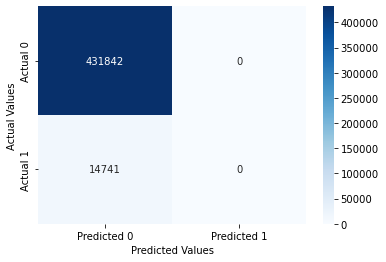

In [73]:
cm = confusion_matrix_train(model_basic_log)

In [46]:
ols_object_basic = smf.ols(formula = 'price~distance+cab_type+time_stamp+destination+source+surge_multiplier+product_id+name', data = train_original)
model_basic = ols_object_basic.fit()
model_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 1.702e+05
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:10:57   Log-Likelihood:            -1.0421e+06
No. Observations:              446583   AIC:                         2.084e+06
Df Residuals:                  446548   BIC:                         2.085e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              0.0118   2.97e-05    397.900      0.000       0.012       0.012
cab_type[T.Uber]                                      -0.7360      0.005   -149.413      0.000      -0.746      -0.726
destination[T.Beacon Hill]                            -0.2963      0.018    -16.196      0.000      -0.332      -0.260
destination[T.Boston University]                      -0.0563      0.015     -3.670      0.000      -0.086      -0.026
destination[T.Fenway]                                 -0.3706      0.015    -24.349      0.000      -0.400      -0.341
destination[T.Financial District]                      0.4086      0.018     22.283      0.000       0.373       0.445
destination[T.Haymarket Square]                        0.1595      0.015     10.329      0.000       0.129       0.190
destination[T.North End]                               0.0135      0.015      0.893      0.372      -0.016       0.043
destination[T.North Station]                           0.2071      0.018     11.300      0.000       0.171       0.243
destination[T.Northeastern University]                -0.0360      0.015     -2.397      0.017      -0.065      -0.007
destination[T.South Station]                          -0.0767      0.015     -5.045      0.000      -0.106      -0.047
destination[T.Theatre District]                        0.2432      0.018     13.300      0.000       0.207       0.279
destination[T.West End]                               -0.0357      0.018     -1.952      0.051      -0.072       0.000
source[T.Beacon Hill]                                 -0.3259      0.018    -17.763      0.000      -0.362      -0.290
source[T.Boston University]                           -0.2914      0.015    -18.866      0.000      -0.322      -0.261
source[T.Fenway]                                      -0.1129      0.015     -7.418      0.000      -0.143      -0.083
source[T.Financial District]                           0.3342      0.019     18.066      0.000       0.298       0.370
source[T.Haymarket Square]                             0.3520      0.016     22.598      0.000       0.321       0.382
source[T.North End]                                    0.5335      0.015     35.438      0.000       0.504       0.563
source[T.North Station]                                0.0622      0.018      3.376      0.001       0.026       0.098
source[T.Northeastern University]                     -0.3185      0.015    -21.013      0.000      -0.348      -0.289
source[T.South Station]                                0.1716      0.015     11.417      0.000       0.142       0.201
source[T.Theatre District]                             0.5228      0.018     28.596      0.000       0.487  

In [47]:
np.sqrt(((test_original.price - model_basic.predict(test_original))**2).mean())

2.4816485788475786

In [48]:
np.sqrt(model_basic.mse_resid)

2.4957401284731286

In [75]:
train_orig_reset = train_original.reset_index()
train_orig_reset.head()

,index,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,bool,surge_dummy
0,0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,True,0
1,3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,True,0
2,4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,True,0
3,5,0.44,Lyft,1545071112138,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,True,0
4,7,1.08,Lyft,1543780384677,Northeastern University,Back Bay,16.5,1.0,474d6376-bc59-4ec9-bf57-4e6d6faeb165,lyft_lux,Lux Black,True,0


In [77]:
ols_object_basic2 = smf.ols(formula = 'price~distance+cab_type+time_stamp+destination+source+surge_multiplier+product_id+name', data = train_orig_reset)
model_basic2 = ols_object_basic2.fit()

In [17]:
import statsmodels.api as sm

In [78]:
#take a look at high leverage points
influence = model_basic2.get_influence()
leverage = influence.hat_matrix_diag
#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal

In [79]:
standardized_residuals

array([ 1.42966141, -0.43628387, -0.42634688, ..., -0.03070566,
        0.31104934,  1.27824812])

In [81]:
#calculate number of high leverage points
average_leverage = (model_basic2.df_model+1)/model_basic2.nobs

high_leverage_threshold = 4*average_leverage

np.sum(leverage>high_leverage_threshold)

520

In [82]:
#np.intersect1d(np.where(np.abs(standardized_residuals)>3)[0],
                                           #(np.where(leverage>high_leverage_threshold)[0]))

In [83]:
#remove high leverage
train_orig_reset_filt = train_orig_reset.drop(np.intersect1d(np.where(np.abs(standardized_residuals)>3)[0],
                                           (np.where(leverage>high_leverage_threshold)[0])))


In [84]:
ols_object_basic3 = smf.ols(formula = 'price~distance+cab_type+time_stamp+destination+source+surge_multiplier+product_id+name', data = train_orig_reset_filt)
model_basic3 = ols_object_basic3.fit()
model_basic3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.729e+05
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:41:31   Log-Likelihood:            -1.0368e+06
No. Observations:              446296   AIC:                         2.074e+06
Df Residuals:                  446261   BIC:                         2.074e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             -0.0112   2.93e-05   -382.189      0.000      -0.011      -0.011
cab_type[T.Uber]                                      -0.7163      0.005   -146.875      0.000      -0.726      -0.707
destination[T.Beacon Hill]                            -0.3007      0.018    -16.599      0.000      -0.336      -0.265
destination[T.Boston University]                      -0.0584      0.015     -3.851      0.000      -0.088      -0.029
destination[T.Fenway]                                 -0.3580      0.015    -23.749      0.000      -0.388      -0.328
destination[T.Financial District]                      0.4057      0.018     22.343      0.000       0.370       0.441
destination[T.Haymarket Square]                        0.1621      0.015     10.601      0.000       0.132       0.192
destination[T.North End]                               0.0205      0.015      1.373      0.170      -0.009       0.050
destination[T.North Station]                           0.1987      0.018     10.952      0.000       0.163       0.234
destination[T.Northeastern University]                -0.0190      0.015     -1.274      0.203      -0.048       0.010
destination[T.South Station]                          -0.0722      0.015     -4.802      0.000      -0.102      -0.043
destination[T.Theatre District]                        0.2344      0.018     12.947      0.000       0.199       0.270
destination[T.West End]                               -0.0453      0.018     -2.497      0.013      -0.081      -0.010
source[T.Beacon Hill]                                 -0.3295      0.018    -18.141      0.000      -0.365      -0.294
source[T.Boston University]                           -0.2833      0.015    -18.522      0.000      -0.313      -0.253
source[T.Fenway]                                      -0.1093      0.015     -7.259      0.000      -0.139      -0.080
source[T.Financial District]                           0.3339      0.018     18.224      0.000       0.298       0.370
source[T.Haymarket Square]                             0.3509      0.015     22.756      0.000       0.321       0.381
source[T.North End]                                    0.5348      0.015     35.885      0.000       0.506       0.564
source[T.North Station]                                0.0617      0.018      3.382      0.001       0.026       0.097
source[T.Northeastern University]                     -0.3140      0.015    -20.917      0.000      -0.343      -0.285
source[T.South Station]                                0.1804      0.015     12.116      0.000       0.151       0.210
source[T.Theatre District]                             0.5075      0.018     28.023      0.000       0.472  

In [85]:
np.sqrt(((test_original.price - model_basic3.predict(test_original))**2).mean())

2.4826334067703697

In [86]:
np.sqrt(model_basic3.mse_resid)

2.4702032854191898

In [23]:
ols_object_distance = smf.ols(formula = 'price~distance', data = train_original)
model_distance = ols_object_distance.fit()
model_distance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                 6.001e+04
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:58:53   Log-Likelihood:            -1.6024e+06
No. Observations:              446583   AIC:                         3.205e+06
Df Residuals:                  446581   BIC:                         3.205e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3540      0.028    363.992      0.000      10.298      10.410
distance       2.8280      0.012    244.972      0.000       2.805       2.851
==============================================================================
Omnibus:                    47856.322   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66554.436
Skew:                           0.856   Prob(JB):                         0.00
Kurtosis:                       3.805   Cond. No.                         6.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
np.sqrt(((test_original.price - model_distance.predict(test_original))**2).mean())

8.751933744449495

In [25]:
np.sqrt(model_distance.mse_resid)

8.751554026422484

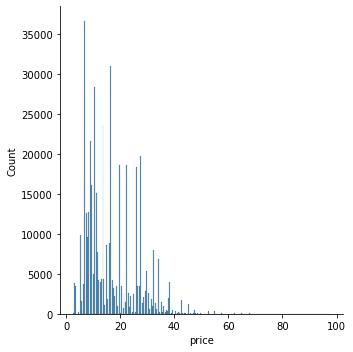

In [26]:
sns.displot(data = train, x = 'price', kind = 'hist')

In [89]:
new_train = train.copy()
new_train = new_train.drop(['price', 'id'], axis = 1)
new_train['log_distance'] = new_train['distance'].apply(lambda x: np.log(x))

In [90]:
new_test = test.copy()
new_test = new_test.drop(['price', 'id'], axis = 1)
new_test['log_distance'] = new_test['distance'].apply(lambda x: np.log(x))

2.1423926612323285

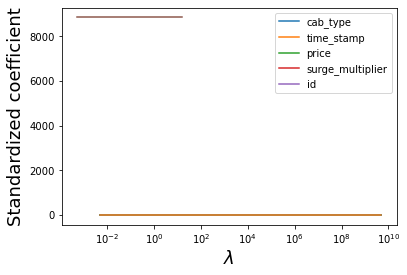

In [91]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

#Taking the log transform of house_price as house prices have a right-skewed distribution
y = np.log(train.price)

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = new_train; 

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-0.4,0.2],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Test dataset
Xtest = new_test

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())

In [100]:
train.columns

Index(['distance', 'cab_type', 'time_stamp', 'price', 'surge_multiplier', 'id',
       'temp_source', 'clouds_source', 'pressure_source', 'rain_source',
       'humidity_source', 'wind_source', 'temp_destination',
       'clouds_destination', 'pressure_destination', 'rain_destination',
       'humidity_destination', 'wind_destination', 'desti_Back Bay',
       'desti_Beacon Hill', 'desti_Boston University', 'desti_Fenway',
       'desti_Financial District', 'desti_Haymarket Square', 'desti_North End',
       'desti_North Station', 'desti_Northeastern University',
       'desti_South Station', 'desti_Theatre District', 'desti_West End',
       'src_Back Bay', 'src_Beacon Hill', 'src_Boston University',
       'src_Fenway', 'src_Financial District', 'src_Haymarket Square',
       'src_North End', 'src_North Station', 'src_Northeastern University',
       'src_South Station', 'src_Theatre District', 'src_West End',
       'pid_55c66225-fbe7-4fd5-9072-eab1ece5e23e',
       'pid_6c84fd89-3f

In [101]:
ols_object = smf.ols(formula = 'price~'+'+'.join(train.columns), data = train)
model = ols_object.fit()
model.summary()

PatsyError: numbers besides '0' and '1' are only allowed with **
    price~distance+cab_type+time_stamp+price+surge_multiplier+id+temp_source+clouds_source+pressure_source+rain_source+humidity_source+wind_source+temp_destination+clouds_destination+pressure_destination+rain_destination+humidity_destination+wind_destination+desti_Back Bay+desti_Beacon Hill+desti_Boston University+desti_Fenway+desti_Financial District+desti_Haymarket Square+desti_North End+desti_North Station+desti_Northeastern University+desti_South Station+desti_Theatre District+desti_West End+src_Back Bay+src_Beacon Hill+src_Boston University+src_Fenway+src_Financial District+src_Haymarket Square+src_North End+src_North Station+src_Northeastern University+src_South Station+src_Theatre District+src_West End+pid_55c66225-fbe7-4fd5-9072-eab1ece5e23e+pid_6c84fd89-3f11-4782-9b50-97c468b19529+pid_6d318bcc-22a3-4af6-bddd-b409bfce1546+pid_6f72dfc5-27f1-42e8-84db-ccc7a75f6969+pid_997acbb5-e102-41e1-b155-9df7de0a73f2+pid_9a0e7b09-b92b-4c41-9779-2ad22b4d779d+pid_lyft+pid_lyft_line+pid_lyft_lux+pid_lyft_luxsuv+pid_lyft_plus+pid_lyft_premier+nm_Black+nm_Black SUV+nm_Lux+nm_Lux Black+nm_Lux Black XL+nm_Lyft+nm_Lyft XL+nm_Shared+nm_UberPool+nm_UberX+nm_UberXL+nm_WAV
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      ^^^^

In [1]:
train_reset = train.reset_index()
ols_object = smf.ols(formula = 'price~distance+cab_type+time_stamp+price+surge_multiplier+id+temp_source+clouds_source+pressure_source+rain_source+humidity_source+wind_source+temp_destination+clouds_destination+pressure_destination+rain_destination+humidity_destination+wind_destination', data = train)

NameError: name 'train' is not defined

In [93]:
train_reset = train.reset_index()
ols_object = smf.ols(formula = 'price~distance+cab_type+time_stamp+price+surge_multiplier+id+temp_source+clouds_source+pressure_source+rain_source+humidity_source+wind_source+temp_destination+clouds_destination+pressure_destination+rain_destination+humidity_destination+wind_destination', data = train)
model = ols_object.fit()
#take a look at high leverage points
influence = model.get_influence()
leverage = influence.hat_matrix_diag
#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal
#create high leverage threshold
average_leverage = (model.df_model+1)/model.nobs
high_leverage_threshold = 4*average_leverage
#remove high leverage
train_filt = train.drop(np.intersect1d(np.where(np.abs(standardized_residuals)>3)[0],
                                           (np.where(leverage>high_leverage_threshold)[0])))

PatsyError: Error evaluating factor: NameError: name 'destination' is not defined
    price~distance+cab_type+time_stamp+destination+source+surge_multiplier+product_id+name
                                       ^^^^^^^^^^^

In [ ]:
#SAME THING AS ABOVE BUT WITHOUT INFLUENTIAL POINTS

#Taking the log transform of house_price as house prices have a right-skewed distribution
y = np.log(train.price)

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = new_train; 

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-0.4,0.2],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Test dataset
Xtest = new_test

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())

2.141934130760698

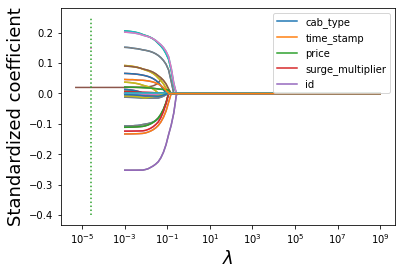

In [92]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)
    
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())

NameError: name 'A' is not defined